### In this notebook every thing same as the previous notebook only diffrence is we are running statarb stratergy on 15min for all pairs

In [1]:
import pandas as pd 
import numpy as np 
import datetime 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import nsepy 
import os
import cufflinks as cf
%matplotlib inline 
plt.style.use('ggplot')

In [2]:
def rolling_adf(series,rolling_n):

    adf_values = list(np.zeros(rolling_n))
    
    for index,datetime in enumerate(series.index):

        if index >= rolling_n:
            start = index - rolling_n

            ser = series.iloc[start:index]
            adf = adfuller(ser, maxlag = 1)

            adf_values.append(adf[0])
            
    return adf_values


def bollinger_band(close_price,
                   n,
                   std):
    
    df = close_price.to_frame()
    df["sma"] = df.iloc[:,0].rolling(n).mean()
    df["rolling_std"] = df.iloc[:,0].rolling(n).std()
    df["upper_band"] = df.sma + (df.rolling_std * std) 
    df["lower_band"] = df.sma - (df.rolling_std * std) 
    df["width"] = df["upper_band"] - df["lower_band"]
    df.dropna(inplace=True)
    
    return df

In [3]:
def spread_prep(x_name,
               y_name,
               train_start,
               train_end,
               test_end,
               resample_freq = "D",
               rolling_adf_n = 400,
               band_thresh = (2,2.5,3),
               band_rolling_n = 60):
    

    path = 'C:\\Users\\sahil\\Documents\\learning\\springborad projects\\capstone_project_1\\data'


    # reading x and y data 
    x = pd.read_csv(path + "\\" + x_name,index_col=0,parse_dates=True)
    y = pd.read_csv(path + "\\" + y_name,index_col=0,parse_dates=True)
    
    # getting a datetime index
    #x.index = pd.to_datetime(x.Date + " " + x.Time)
    #y.index = pd.to_datetime(y.Date + " " + y.Time)

    # getting close price of x and y convetring it into dataframes
    x = x.Close.to_frame()
    y = y.Close.to_frame()

    x.columns = [x_name]
    y.columns = [y_name]
    
    # concatnating x and y into one dataframe
    df = pd.concat([x,y],axis = 1)

    # dropping nan values that might have genrated after concatanting
    df.dropna(inplace=True)
    df.sort_index(inplace=True)
    
    # resample the df to desired freq and dropping nan if genrated after resampling 
    df = df.resample(resample_freq).last().dropna().copy()
    
    
    # getting data from train_start to test end
    df = df.loc[train_start:test_end].copy()

    # getting training data ready 
    X_train = df.loc[train_start:train_end,x_name]
    y_train = df.loc[train_start:train_end,y_name]


    # training the model
    model = sm.OLS(y_train,X_train)
    model = model.fit()


    # calculating spread on full train and test data 
    spread = (df.loc[:,y_name] - (df.loc[:,x_name] * model.params[0]))
    spread.name = "spread"


    spread = bollinger_band(spread,
                            band_rolling_n,
                            band_thresh[0])

    # calculatin upper band  2 and 3
    spread["upper_band2"] = spread.sma + (spread.rolling_std * band_thresh[1])
    spread["upper_band3"] = spread.sma + (spread.rolling_std * band_thresh[2])

    # getting lower band 2 and 3
    spread["lower_band2"] = spread.sma - (spread.rolling_std * band_thresh[1])
    spread["lower_band3"] = spread.sma - (spread.rolling_std * band_thresh[2])


    # getting rolling adf value
    spread["rolling_adf"] = rolling_adf(spread.spread,
                                        rolling_n=rolling_adf_n)
    
    return spread

In [4]:
def mean_reversion_backtest(sample,
                            test_start,
                            test_end,
                            adf_thresh = -2.5):

    
    sample = sample.loc[test_start:test_end].copy()
    
    # constant variables 
    thresh = adf_thresh

    entry_time = []
    exit_time = []

    trade_side = []
    adf_value = []

    entry_price = []
    exit_price = []

    target_price = []
    stop_price = []


    # temp variables
    trade_taken = False
    target = 0
    stop = 0
    
    # running backtest only on test data 
    for index,datetime in enumerate(sample.index):


        # current data variables 
        current_datetime = datetime
        current_spread = sample.iloc[index].loc["spread"]
        sma = sample.iloc[index].loc["sma"]
        adf = sample.iloc[index].loc["rolling_adf"]

        upper_band = sample.iloc[index].loc["upper_band"]
        upper_band2 = sample.iloc[index].loc["upper_band2"]
        upper_band3 = sample.iloc[index].loc["upper_band3"]

        lower_band = sample.iloc[index].loc["lower_band"]
        lower_band2 = sample.iloc[index].loc["lower_band2"]
        lower_band3 = sample.iloc[index].loc["lower_band3"]


        # stratergy logic below 

        # if any trade is not taken and adf value not below a desired thresh dont look for new trades 
        if (adf > thresh) and (trade_taken == False):
            continue


        # cheking for fresh short trade stop
        elif ((current_spread >= upper_band) and (current_spread <= upper_band2)) and (trade_taken == False):

            trade_taken = "short_entered"
            target = sma
            stop = upper_band3

            # appending trade details
            entry_time.append(current_datetime)
            adf_value.append(adf)
            trade_side.append("short")
            entry_price.append(current_spread)
            target_price.append(target)
            stop_price.append(stop)



        # cheking for short trade stop
        elif (trade_taken == "short_entered") and (current_spread > stop):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(current_spread)


        # cheking for short trade target 
        elif (trade_taken == "short_entered") and (current_spread < target):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(current_spread)


        # cheking for fresh long trade 
        elif ((current_spread < lower_band) and (current_spread > lower_band2)) and (trade_taken == False):

            trade_taken = "long_entered"
            target = sma
            stop = lower_band3

            # appending trade details
            entry_time.append(current_datetime)
            adf_value.append(adf)
            trade_side.append("long")
            entry_price.append(current_spread)
            target_price.append(target)
            stop_price.append(stop)


        # checking for long trade stop 
        elif (trade_taken == "long_entered") and (current_spread < stop):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(current_spread)
            

        # checking for long trade target 
        elif (trade_taken == "long_entered") and (current_spread > target):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(current_spread)




        # if last data entry and we are still holding a trade then sqaure off the trade 
        elif (index == (len(sample) - 1)) and (trade_taken != False):

            trade_taken = False

            # appending trade details
            exit_time.append(current_datetime)
            exit_price.append(current_spread)
            
    
    # creating a trade sheet out of all recorded trades details 
    trade_sheet = pd.DataFrame({"entry_time":entry_time,
                               "exit_time":exit_time,
                               "adf_value":adf_value,
                               "trade_side":trade_side,
                               "adf_value":adf_value,
                               "entry_price":entry_price,
                               "exit_price":exit_price,
                               "target_price":target_price,
                               "stop_price":stop_price})

    # calculating pnl from trade sheet
    trade_sheet["pnl"] = 0
    
   
    con_1 = trade_sheet.trade_side == "short"
    con_2 = trade_sheet.trade_side == "long"

    trade_sheet.loc[con_1,"pnl"] = trade_sheet.loc[con_1,"entry_price"] - trade_sheet.loc[con_1,"exit_price"]
    trade_sheet.loc[con_2,"pnl"] = trade_sheet.loc[con_2,"exit_price"] - trade_sheet.loc[con_2,"entry_price"]
    
    return trade_sheet


In [5]:
#pairs = sorted(pairs)

#p = []
#for pair in pairs:
#    print(sorted(pair))
#    p.append(str(sorted(pair)))
    
#p = pd.Series(p)
#p.loc[~(p.duplicated())]

In [6]:
### running stat arb stratergy on all pa

In [7]:
pairs =    [['AXISBANK.csv', 'HDFC.csv'],
        ['AXISBANK.csv', 'HDFCBANK.csv'],
       ['AXISBANK.csv', 'KOTAKBANK.csv'],
            ['AXISBANK.csv', 'SBIN.csv'],
     ['BANKBARODA.csv', 'ICICIBANK.csv'],
          ['BANKBARODA.csv', 'SBIN.csv'],
       ['AXISBANK.csv', 'BANKNIFTY.csv'],
           ['BANKNIFTY.csv', 'HDFC.csv'],
       ['BANKNIFTY.csv', 'HDFCBANK.csv'],
      ['BANKNIFTY.csv', 'ICICIBANK.csv'],
     ['BANKNIFTY.csv', 'KOTAKBANK.csv'],
          ['BANKNIFTY.csv', 'SBIN.csv'],
           ['HDFC.csv', 'HDFCBANK.csv'],
          ['HDFC.csv', 'KOTAKBANK.csv'],
           ['HDFC.CSV', 'HDFCBANK.csv'],
      ['HDFCBANK.csv', 'KOTAKBANK.csv'],
          ['ICICIBANK.csv', 'SBIN.csv'],
    ['BANKBARODA.csv', 'KOTAKBANK.csv'],
         ['BANKBARODA.csv', 'SBIN.csv']]

In [8]:
# traing span
train_start = "2014"
train_end = "2015"

# testing span
test_start = "2016"
test_end = "2020"

resample_freq =  "15T" 
rolling_adf_n = 400  # rolling n for adf test
band_thresh = (2,2.5,3)
band_rolling_n = 60 
adf_thresh  = -2.5 


backtest = {}

for x_name,y_name in pairs:
    print(x_name," ",y_name)

    data = spread_prep(x_name,
                       y_name,
                       train_start,
                       train_end,
                       test_end,
                       resample_freq = resample_freq,
                       rolling_adf_n = rolling_adf_n,
                       band_thresh= band_thresh,
                       band_rolling_n=band_rolling_n)

    trade_sheet = mean_reversion_backtest(data,
                                          test_start = test_start,
                                          test_end = test_end,
                                          adf_thresh=adf_thresh)

    trade_sheet["pair"] = x_name + "_" + y_name
    backtest[x_name + "_" + y_name] = trade_sheet

AXISBANK.csv   HDFC.csv
AXISBANK.csv   HDFCBANK.csv
AXISBANK.csv   KOTAKBANK.csv
AXISBANK.csv   SBIN.csv
BANKBARODA.csv   ICICIBANK.csv
BANKBARODA.csv   SBIN.csv
AXISBANK.csv   BANKNIFTY.csv
BANKNIFTY.csv   HDFC.csv
BANKNIFTY.csv   HDFCBANK.csv
BANKNIFTY.csv   ICICIBANK.csv
BANKNIFTY.csv   KOTAKBANK.csv
BANKNIFTY.csv   SBIN.csv
HDFC.csv   HDFCBANK.csv
HDFC.csv   KOTAKBANK.csv
HDFC.CSV   HDFCBANK.csv
HDFCBANK.csv   KOTAKBANK.csv
ICICIBANK.csv   SBIN.csv
BANKBARODA.csv   KOTAKBANK.csv
BANKBARODA.csv   SBIN.csv


In [9]:
backtest.keys()

dict_keys(['AXISBANK.csv_HDFC.csv', 'AXISBANK.csv_HDFCBANK.csv', 'AXISBANK.csv_KOTAKBANK.csv', 'AXISBANK.csv_SBIN.csv', 'BANKBARODA.csv_ICICIBANK.csv', 'BANKBARODA.csv_SBIN.csv', 'AXISBANK.csv_BANKNIFTY.csv', 'BANKNIFTY.csv_HDFC.csv', 'BANKNIFTY.csv_HDFCBANK.csv', 'BANKNIFTY.csv_ICICIBANK.csv', 'BANKNIFTY.csv_KOTAKBANK.csv', 'BANKNIFTY.csv_SBIN.csv', 'HDFC.csv_HDFCBANK.csv', 'HDFC.csv_KOTAKBANK.csv', 'HDFC.CSV_HDFCBANK.csv', 'HDFCBANK.csv_KOTAKBANK.csv', 'ICICIBANK.csv_SBIN.csv', 'BANKBARODA.csv_KOTAKBANK.csv'])

In [10]:
bbb = pd.DataFrame(index = pd.date_range(start = "2016",end="2020",freq = "15min"))

for key in backtest.keys():
    b = backtest[key]
    b.set_index('entry_time',inplace=True)
    bbb[key] = b.pnl
    print(key," " ,b.pnl.sum())

AXISBANK.csv_HDFC.csv   102.25541319062211
AXISBANK.csv_HDFCBANK.csv   195.19844423300424
AXISBANK.csv_KOTAKBANK.csv   58.053574182156524
AXISBANK.csv_SBIN.csv   91.40865003039568
BANKBARODA.csv_ICICIBANK.csv   24.38601897136587
BANKBARODA.csv_SBIN.csv   20.99135885258913
AXISBANK.csv_BANKNIFTY.csv   10899.312569999474
BANKNIFTY.csv_HDFC.csv   216.3427421053509
BANKNIFTY.csv_HDFCBANK.csv   -33.73726912150346
BANKNIFTY.csv_ICICIBANK.csv   4.923009952597425
BANKNIFTY.csv_KOTAKBANK.csv   -82.8494049765012
BANKNIFTY.csv_SBIN.csv   16.016611177712235
HDFC.csv_HDFCBANK.csv   81.31980434702825
HDFC.csv_KOTAKBANK.csv   111.44258259152048
HDFC.CSV_HDFCBANK.csv   81.31980434702825
HDFCBANK.csv_KOTAKBANK.csv   246.02289407324133
ICICIBANK.csv_SBIN.csv   4.766456581653557
BANKBARODA.csv_KOTAKBANK.csv   -87.73692828816252


In [11]:
bbb.fillna(0,inplace=True)

### over all stratergy pnl 

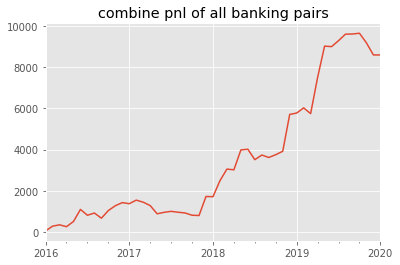

In [12]:
bbb.resample("M").sum().sum(axis = 1).cumsum().plot()
plt.title("combine pnl of all banking pairs")
plt.show()

### creating dataframe with total pnl for every pair

In [13]:
total_pnl = pd.DataFrame(index = list(backtest.keys()))
total_pnl["pair_pnl"] = 0
for key in backtest.keys():
    total_pnl.loc[key] = backtest[key].pnl.sum() 

In [14]:
total_pnl

,pair_pnl
AXISBANK.csv_HDFC.csv,102.255413
AXISBANK.csv_HDFCBANK.csv,195.198444
AXISBANK.csv_KOTAKBANK.csv,58.053574
AXISBANK.csv_SBIN.csv,91.408650
BANKBARODA.csv_ICICIBANK.csv,24.386019
BANKBARODA.csv_SBIN.csv,20.991359
AXISBANK.csv_BANKNIFTY.csv,10899.312570
BANKNIFTY.csv_HDFC.csv,216.342742
BANKNIFTY.csv_HDFCBANK.csv,-33.737269
BANKNIFTY.csv_ICICIBANK.csv,4.923010


### lets plot cumalative pnl of some profit making pairs 

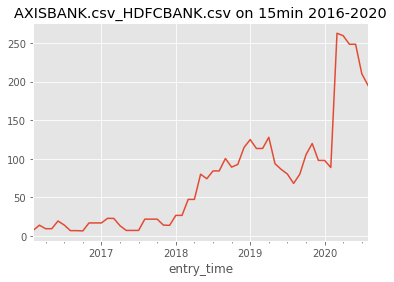

In [15]:
backtest['AXISBANK.csv_HDFCBANK.csv'].pnl.resample("M").sum().cumsum().plot()
plt.title('AXISBANK.csv_HDFCBANK.csv on 15min 2016-2020')
plt.show()

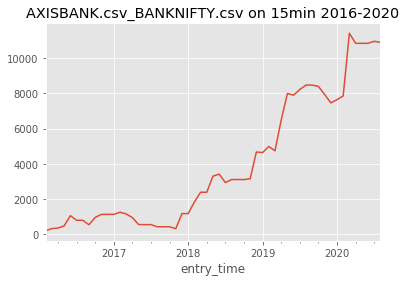

In [16]:
backtest['AXISBANK.csv_BANKNIFTY.csv'].pnl.resample("M").sum().cumsum().plot()
plt.title('AXISBANK.csv_BANKNIFTY.csv on 15min 2016-2020')
plt.show()

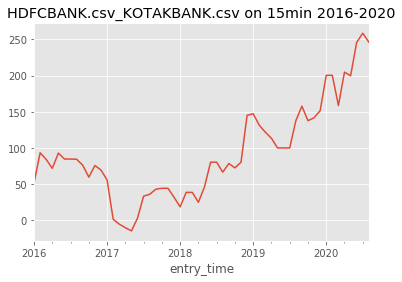

In [17]:
backtest['HDFCBANK.csv_KOTAKBANK.csv'].pnl.resample("M").sum().cumsum().plot()
plt.title('HDFCBANK.csv_KOTAKBANK.csv on 15min 2016-2020')
plt.show()

### lets plot cumalative pnl of some loss making pairs 

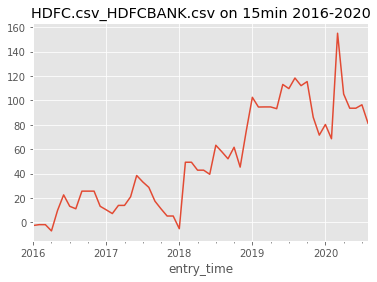

In [18]:
backtest['HDFC.csv_HDFCBANK.csv'].pnl.resample("M").sum().cumsum().plot()
plt.title('HDFC.csv_HDFCBANK.csv on 15min 2016-2020')
plt.show()

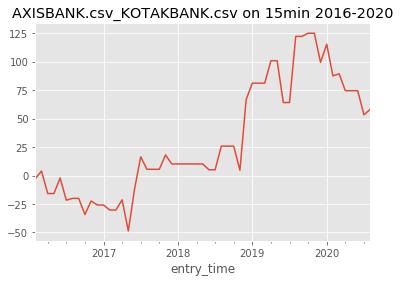

In [19]:
backtest['AXISBANK.csv_KOTAKBANK.csv'].pnl.resample("M").sum().cumsum().plot()
plt.title('AXISBANK.csv_KOTAKBANK.csv on 15min 2016-2020')
plt.show()